In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# nltk lib
import nltk
from nltk.corpus import stopwords
import re
import string
from spacy.lang.en import English
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob as tb # for sentence polarity

# ML libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [15]:
data = pd.read_csv('FakeNewsData.csv', usecols=[1, 2, 3])
data.head()

,Headline,Body,Stance
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled filmSeth...,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,agree
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,unrelated
4,Spider burrowed through tourist stomach and up...,"Fear not arachnophobes, the story of Bunbury ""...",disagree


In [17]:
test.Stance.value_counts()

unrelated    32886
discuss       8011
agree         3316
disagree       761
Name: Stance, dtype: int64

In [181]:
# Found some chinese characters in the text. So looking at all non english characters present
a = []
for text in data['Body']:
    chars = re.findall("[^\x00-\x7F]+", text, flags=re.IGNORECASE)
    a.append(chars)
a

[['’', '’', '—', '—'],
 [],
 [],
 [],
 [],
 ['–', '—', '—', '—', '—', '查理', '—'],
 ['£'],
 [],
 ['’',
  '’',
  '“',
  '”',
  '—',
  '’',
  '—',
  '’',
  '–',
  '–',
  '’',
  '‘',
  '’',
  '‘',
  '’',
  '’',
  '’',
  '’',
  '’',
  '’',
  '—'],
 ['‘', '’', '’', '’', '“', '”', '“', '”“', '…', '”'],
 ['—',
  '—',
  '“',
  '”',
  '’',
  '“',
  '”',
  '’',
  '’',
  '“',
  '”',
  '“',
  '”',
  '“',
  '”',
  '\xad',
  '“',
  '”',
  '“',
  '”',
  '“',
  '”',
  '“',
  '”',
  '“',
  '”',
  '\xad',
  '’',
  '“',
  '”',
  '—',
  '“',
  '”',
  '’',
  '“',
  '”',
  '’',
  '—',
  '’',
  '—'],
 [],
 [],
 ['—',
  '“',
  '”',
  '—',
  '—',
  '“',
  '”',
  '“',
  '”',
  '—',
  '“',
  '”',
  '“',
  '”',
  '“',
  '”',
  '—',
  '“',
  '”',
  '’',
  '“',
  '”',
  '“',
  '”',
  '“',
  '”',
  '’',
  '’',
  '“',
  '”',
  '“',
  '’',
  '”'],
 [],
 [],
 ['—', '—', '—', '—', '…', '—', '—'],
 ['’', '“', '”', '\u200b', '’', '“', '”', '“', '”', '“', '”', '’', '“', '”'],
 [],
 [],
 ['—', '—'],
 [],
 ['—', '’', '“', '”'

In [4]:
clean_news = data.copy()

In [5]:
def text_cleaning(text):
    """
        decontracting combined words
    """
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    '''
        Make text lowercase, remove text in square brackets,remove links, remove punctuation 
        and remove words containing numbers.
    '''
    #text = re.sub("(\w)([A-Z])", r"\1 \2", text) #inserts space in words like eg:HoaxShah Rukh, Social MediaEminem, FakeEbola
    text = str(text).lower()
    #text = re.sub('\[.*?\]', '', text)
    text = re.sub('http\S+', '', text) #remove links
    text = re.sub("\([^()]*\)", "", text) # remove words containing brackets
    text = re.sub('\w*\d\w*', '', text) #remove words containing numbers
    text = re.sub('[^\w\s]', ' ', text) #remove all punctuation
    text = re.sub("[^\x00-\x7F]+", '', text) #removes non english (non ASCII) characters eg: chinese text
    text = re.sub("\s+[a-zA-Z]\s+", ' ', text) #removes single letter words 
    text = re.sub('\n', '', text) #removes breaks
    text = re.sub(' +', ' ', text) #removes extra spaces
    text = re.sub("^\s+", "", text) #remove spaces from start and ending of text
    
    return text

In [6]:
clean_news['body_clean'] = clean_news['Body'].apply(lambda x: text_cleaning(x))
clean_news['head_clean'] = clean_news['Headline'].apply(lambda x: text_cleaning(x))

#### Lemmatizing and Stopwords removal

In [7]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(text):
    sent = nlp(text)
    lemmatized = ' '.join([token.lemma_ for token in sent if (token.is_stop==False)])
    
    return lemmatized

In [8]:
clean_news['head_lemma'] = clean_news['head_clean'].apply(lambda x: lemmatize(x))
clean_news['body_lemma'] = clean_news['body_clean'].apply(lambda x: lemmatize(x))

In [9]:
#clean_news['news'] = clean_news['head_clean']+clean_news['body_clean']
news = clean_news.drop(['Headline', 'Body', 'body_clean', 'head_clean'], axis=1)

In [11]:
news.head()

,Stance,head_lemma,body_lemma
0,unrelated,police find mass grave body near mexico town s...,danny boyle direct untitled filmseth rogen eye...
1,agree,hundred palestinian flee flood gaza israel ope...,hundred palestinian evacuate home sunday morni...
2,unrelated,christian bale pass role steve job actor repor...,year old moscow resident hospitalize wound int...
3,unrelated,hbo apple talk month apple tv stream service l...,canadian soldier shoot canadian war memorial o...
4,disagree,spider burrow tourist stomach chest,fear arachnophobe story bunbury spiderman pert...


## EDA

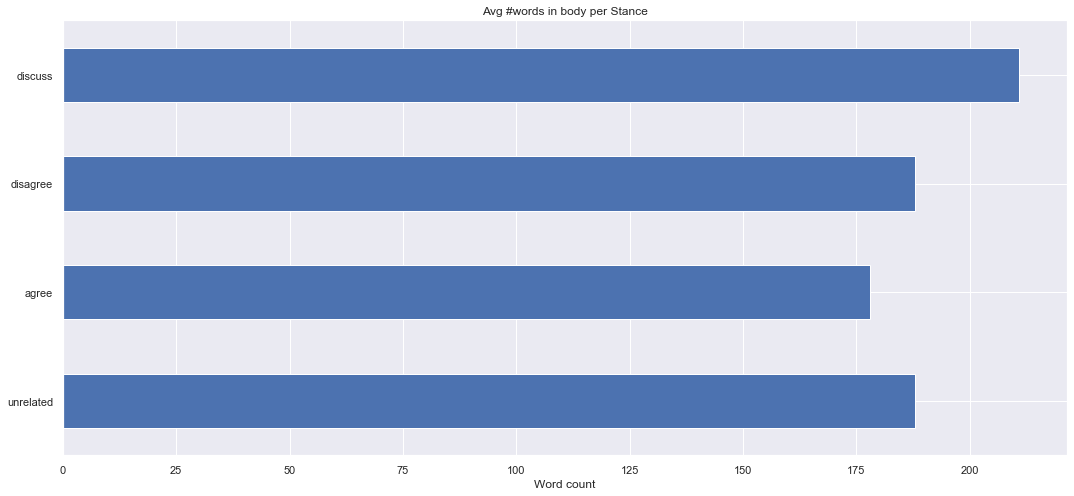

In [10]:
# Avg number of words per stance
news['word_count'] = [len(s.split()) for s in news['body_lemma']]

num_words = {}
for stance in news.Stance.unique():
    df = news[news['Stance']==stance]
    num_words[stance] = int(np.ceil(df.word_count.mean()))

series = pd.Series(num_words)

sns.set()
fig = plt.figure(figsize=(18, 8))
series.plot(kind='barh')
plt.title('Avg #words in body per Stance')
plt.xlabel('Word count')
plt.show()
#plt.savefig('numWords.png')
#files.download('numWords.png')
#plt.close(fig)

#### avg words are similar in all the classes with 180 - 200 per news. A boxplot would give much clearer information

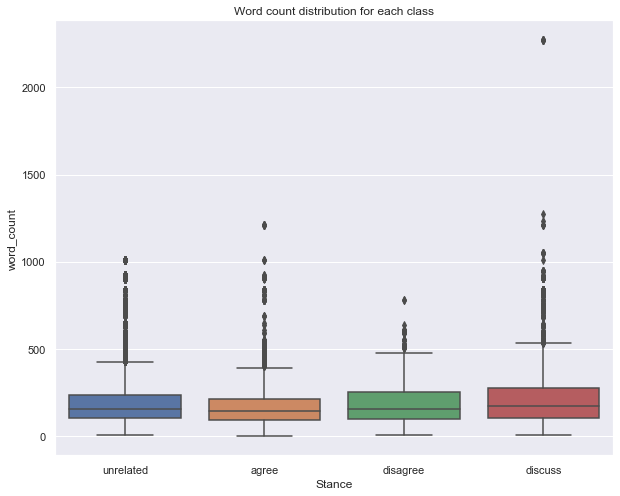

In [197]:
sns.set()
plt.figure(figsize=(10, 8))
sns.boxplot(x='Stance', y='word_count', data=news) 
plt.title('Word count distribution for each class')
plt.show()

#### Number of words for all samples lie at around 500 with some outliers reaching 1000 words and above. Agree stance, i.e body agreeing with headline content has the least number of words whereas disagree and unrelated have greater word count. We can assume that fake news content has more number of words than true news. 

### Top words in the news

In [242]:
def top_n_words(corpus, n=None, ngrams=1):
    vec = CountVectorizer(ngram_range=(ngrams, ngrams), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return sorted(words_freq[:n], key = lambda x: x[1], reverse=True)

top_n_words(news[news['Stance']=='unrelated'].body_lemma, 10)

[('say', 111766),
 ('report', 46155),
 ('apple', 34103),
 ('state', 31167),
 ('year', 31036),
 ('tell', 30436),
 ('time', 27063),
 ('video', 26194),
 ('people', 26189),
 ('man', 24989)]


 -------------------------------------------------- UNRELATED --------------------------------------------------


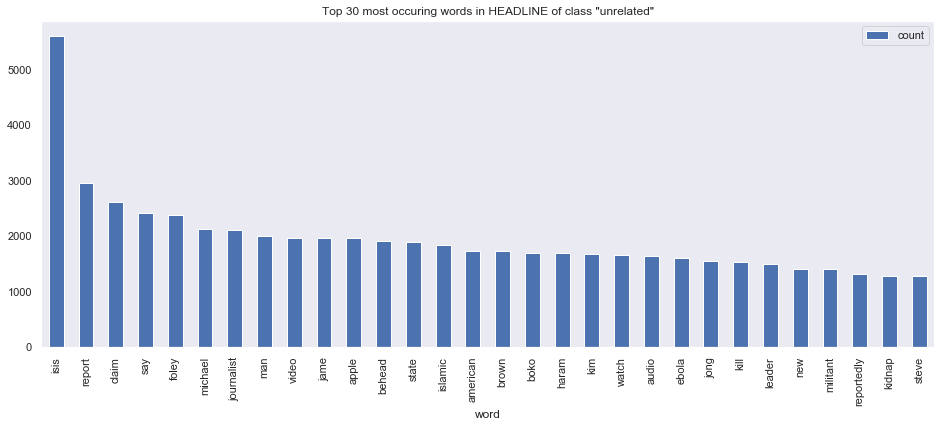

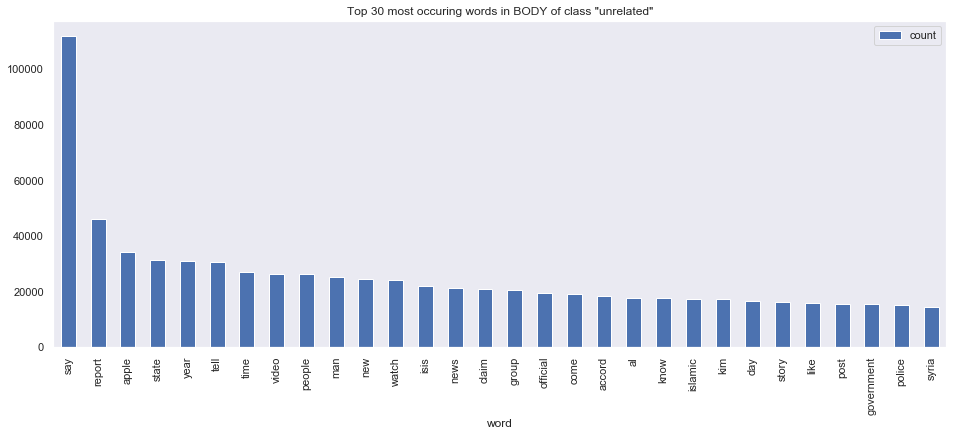


 -------------------------------------------------- AGREE --------------------------------------------------


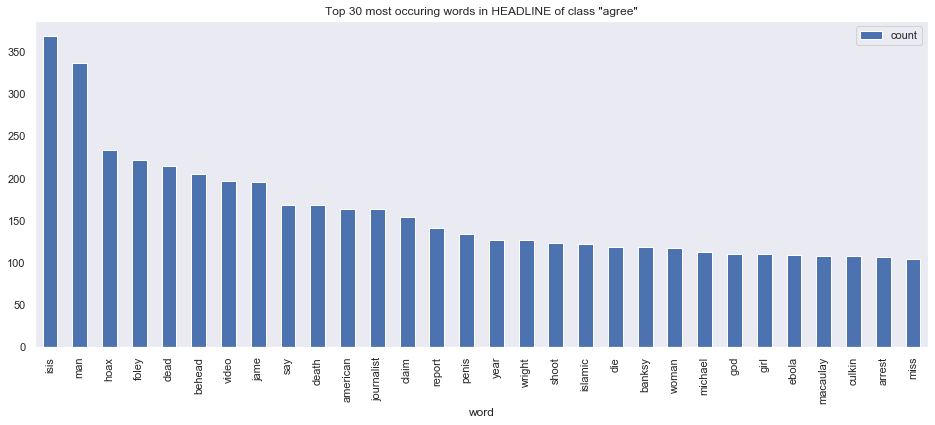

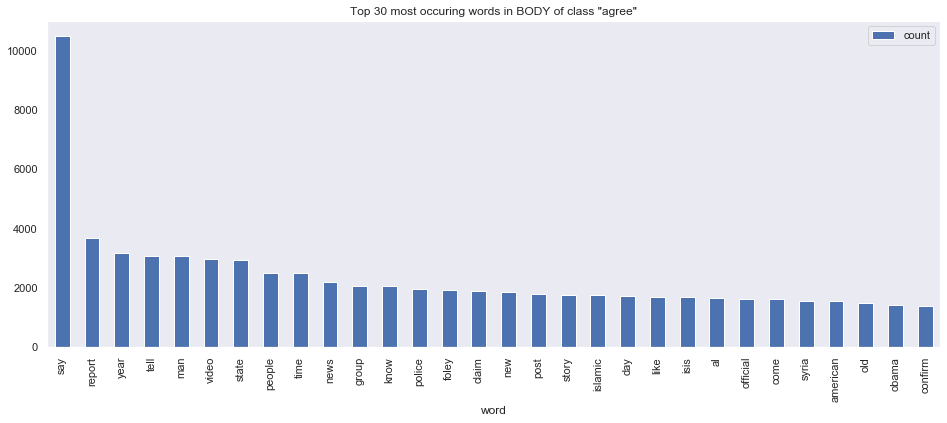


 -------------------------------------------------- DISAGREE --------------------------------------------------


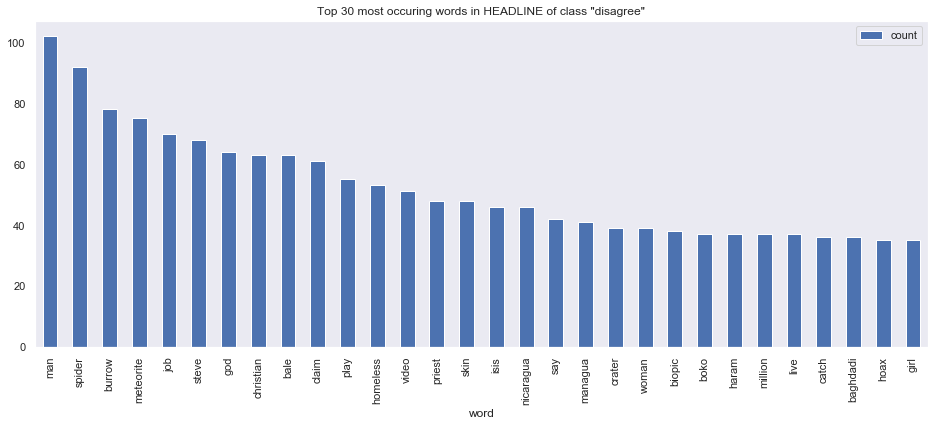

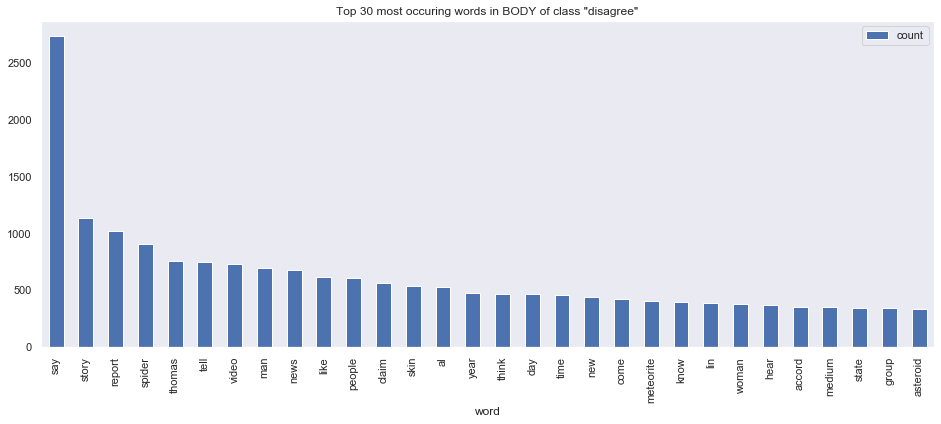


 -------------------------------------------------- DISCUSS --------------------------------------------------


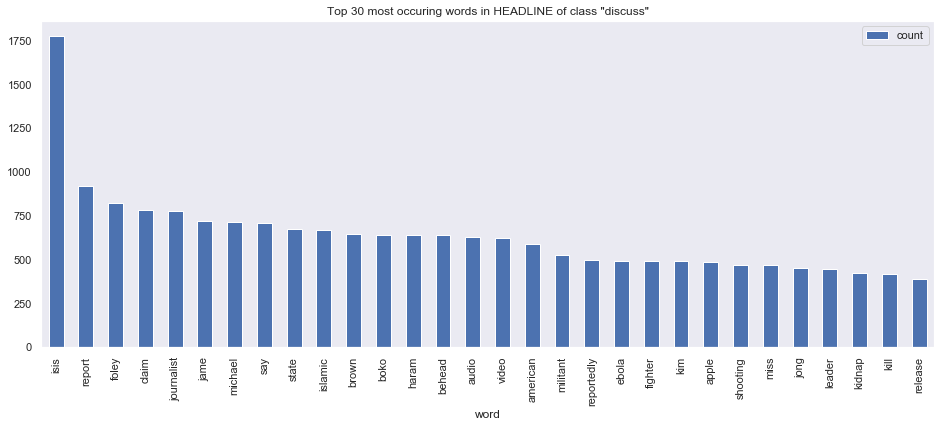

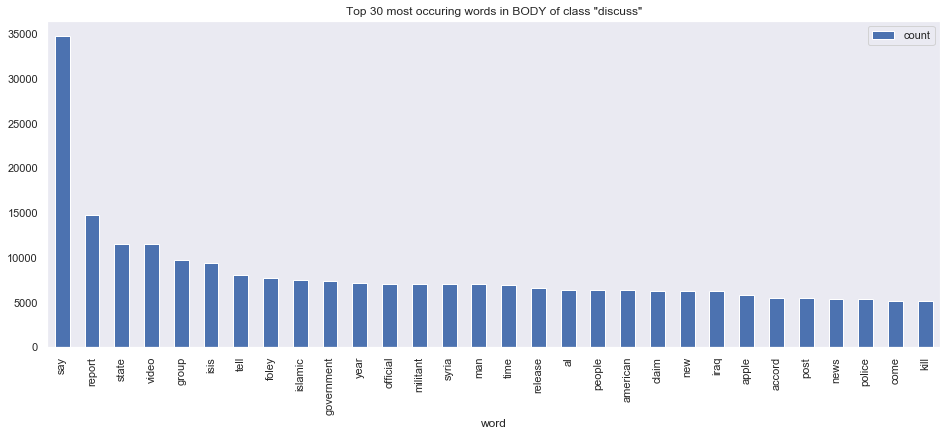

In [246]:
for cls in news.Stance.unique():
    print('\n', '-'*50, cls.upper(), '-'*50)
    n = 30
    common_words_head = top_n_words(news[news['Stance']==cls].head_lemma, n)
    common_words_body = top_n_words(news[news['Stance']==cls].body_lemma, n)
    
    df_freq_head = pd.DataFrame(common_words_head, columns = ['word' , 'count'])
    df_freq_head.set_index(['word'], inplace=True)
    df_freq_body = pd.DataFrame(common_words_body, columns = ['word' , 'count'])
    df_freq_body.set_index(['word'], inplace=True)
    
    df_freq_head.plot.bar(figsize=(16, 6), sort_columns=True)
    plt.title('Top {} most occuring words in HEADLINE of class "{}"'.format(n, cls))
    df_freq_body.plot.bar(figsize=(16, 6), sort_columns=True)
    plt.title('Top {} most occuring words in BODY of class "{}"'.format(n, cls))
    plt.show()

the word 'say' is the most frequent in all the classes. followed by 'tell'. These words dont have much value. The word 'report' also shows up 2nd most frequently. Makes sense since the data is about news and reporting. 

DISAGREE class contains:
'spider', 'skin', 'meteorite', 'asteroid', 'earth', 'god' etc. which says the news is completely random and covers abstract topics.

DISCUSS class is more likely similar to the agree class where they have most used common words. Probably the discuss class contains much of the agreed perception. 

AGREE class contains:
'people', 'news', 'police', 'islamic', 'isis', 'official', 'obama', 'government' etc which conveys the news is talking about real things and issues when compared to other classes. 

Let's see bigrams so we can get a better clarity.


 -------------------------------------------------- UNRELATED --------------------------------------------------


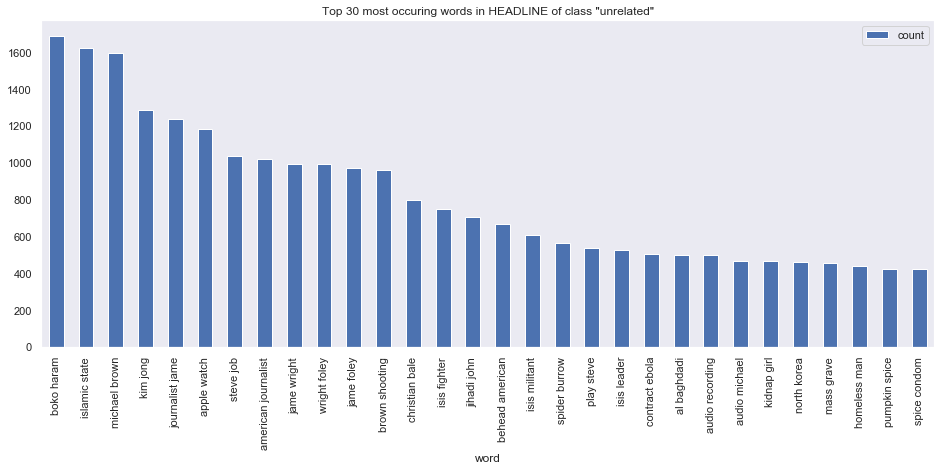

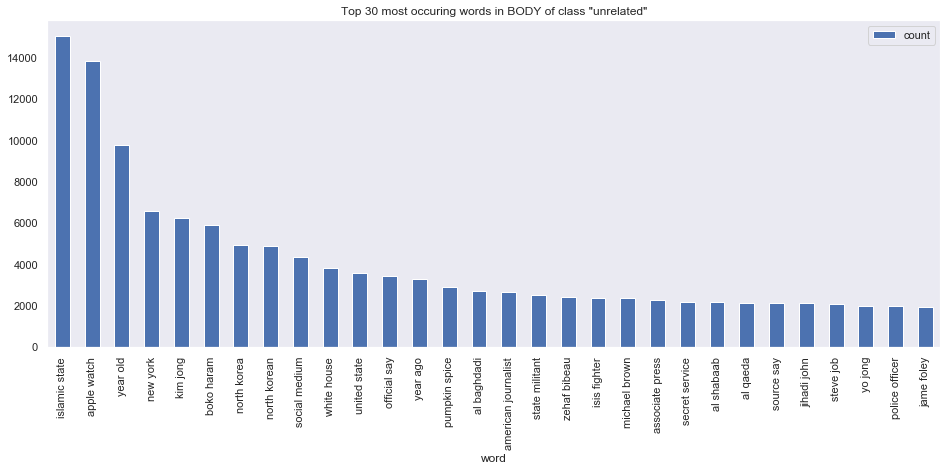


 -------------------------------------------------- AGREE --------------------------------------------------


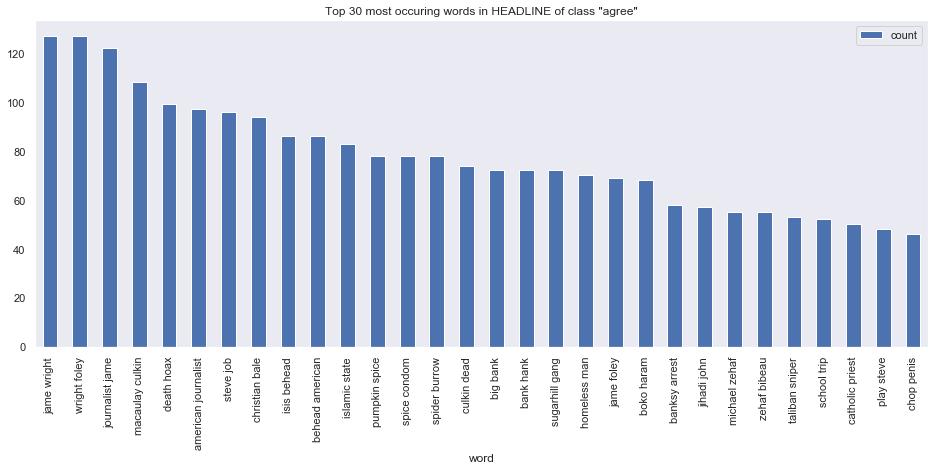

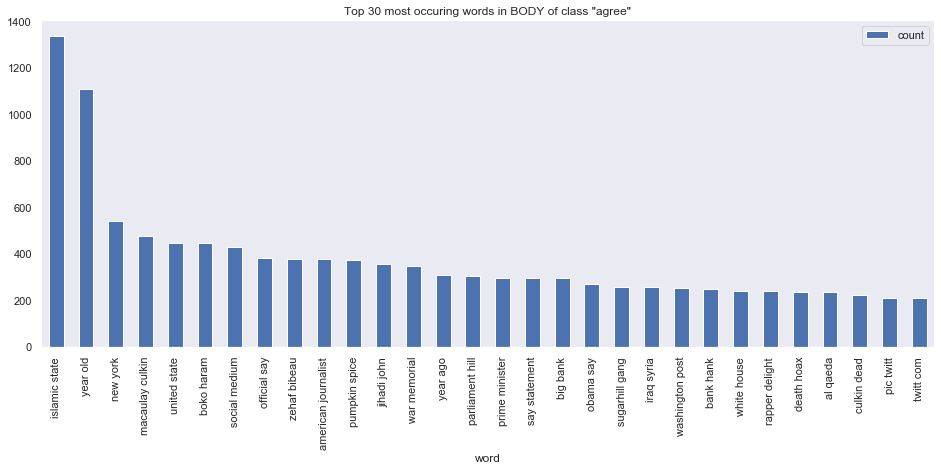


 -------------------------------------------------- DISAGREE --------------------------------------------------


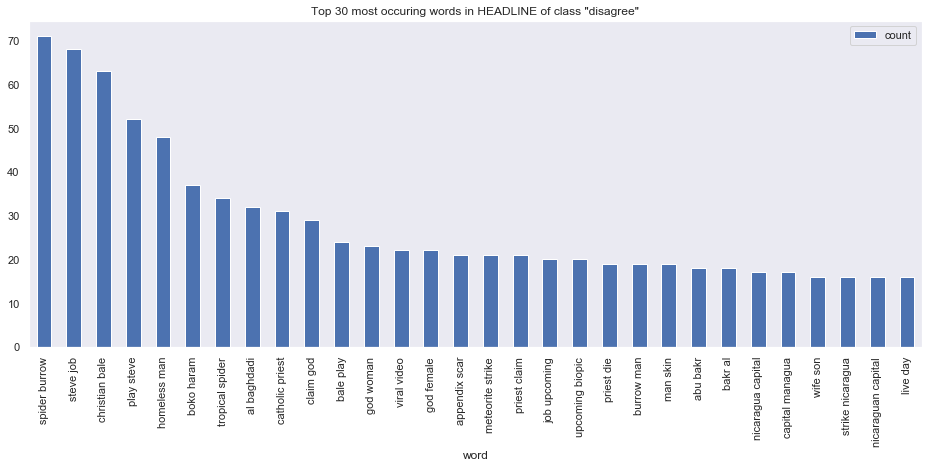

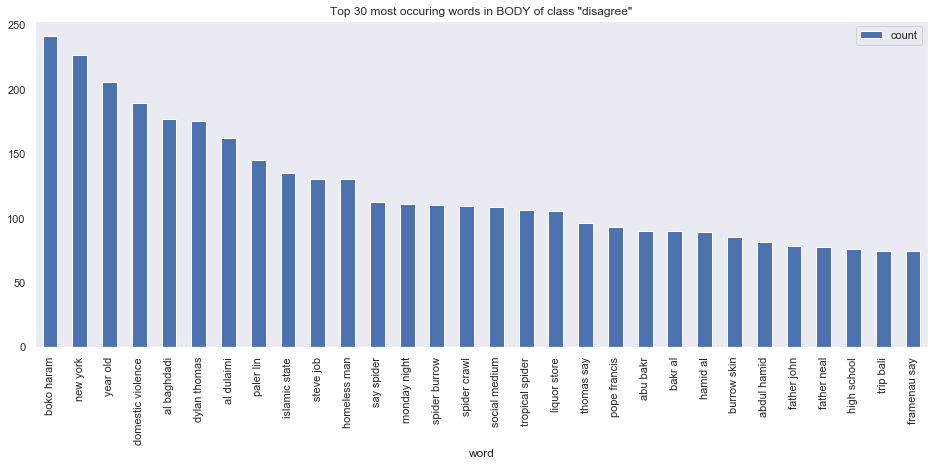


 -------------------------------------------------- DISCUSS --------------------------------------------------


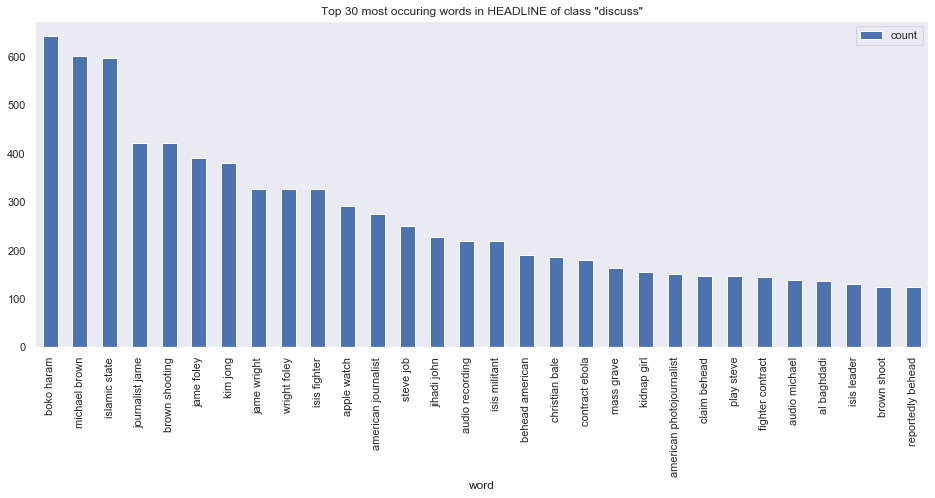

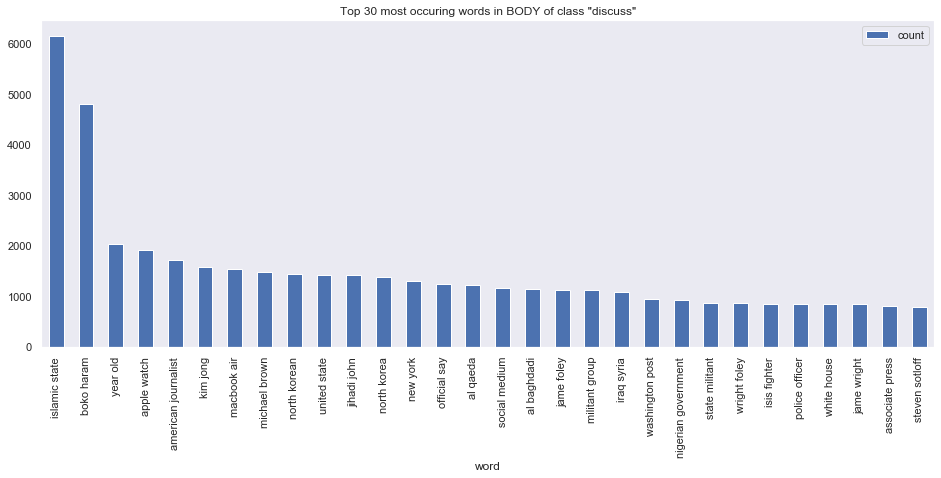

In [248]:
# TOP Bigrams
for cls in news.Stance.unique():
    print('\n', '-'*50, cls.upper(), '-'*50)
    n = 30
    common_words_head = top_n_words(news[news['Stance']==cls].head_lemma, n, 2)
    common_words_body = top_n_words(news[news['Stance']==cls].body_lemma, n, 2)
    
    df_freq_head = pd.DataFrame(common_words_head, columns = ['word' , 'count'])
    df_freq_head.set_index(['word'], inplace=True)
    df_freq_body = pd.DataFrame(common_words_body, columns = ['word' , 'count'])
    df_freq_body.set_index(['word'], inplace=True)
    
    df_freq_head.plot.bar(figsize=(16, 6), sort_columns=True)
    plt.title('Top {} most occuring words in HEADLINE of class "{}"'.format(n, cls))
    df_freq_body.plot.bar(figsize=(16, 6), sort_columns=True)
    plt.title('Top {} most occuring words in BODY of class "{}"'.format(n, cls))
    plt.show()

Bigrams reveal much clearer information. 

UNRELATED: Headlines talk about journalist, black people shooting, steve jobs etc whereas body talks about terrorism and militant related activities like boko haram, islamic state, isis etc. 

AGREE has clearly similar topics in headlines as well as bodies.

DISAGREE talks about completely abstract and irrelelvant topics. 

DISCUSS is similar to AGREE as seen before.

UNRELATED


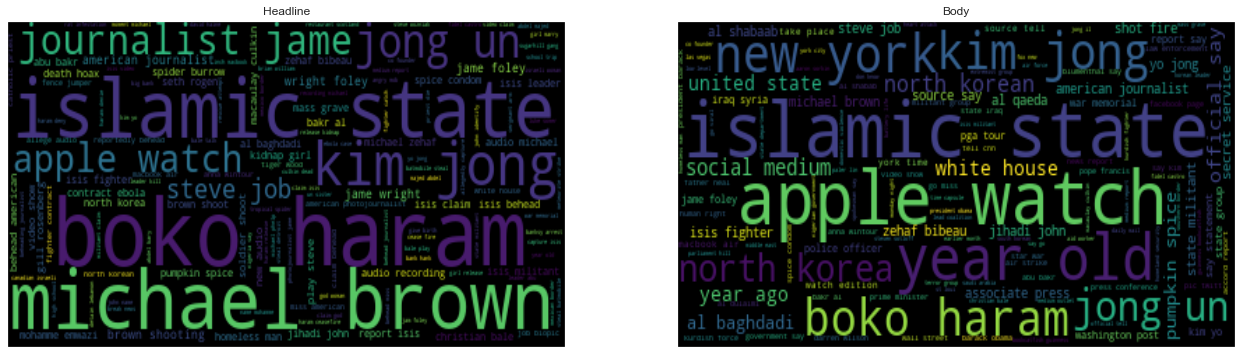

AGREE


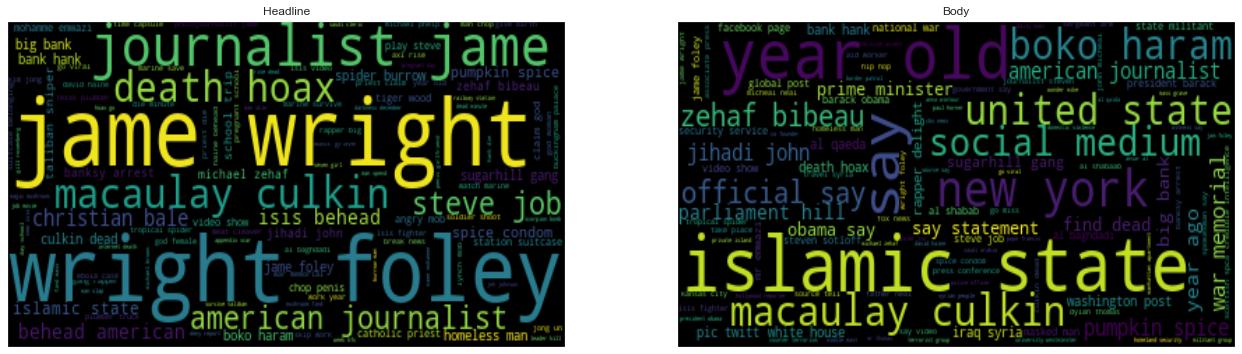

DISAGREE


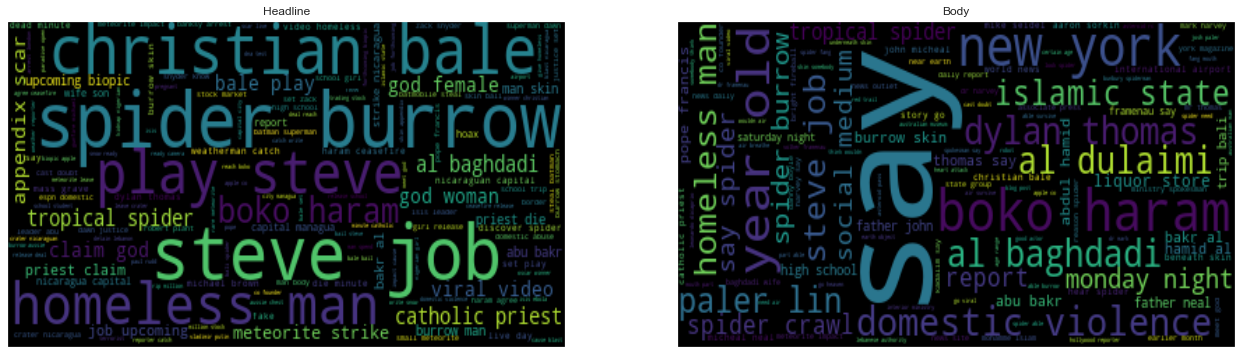

DISCUSS


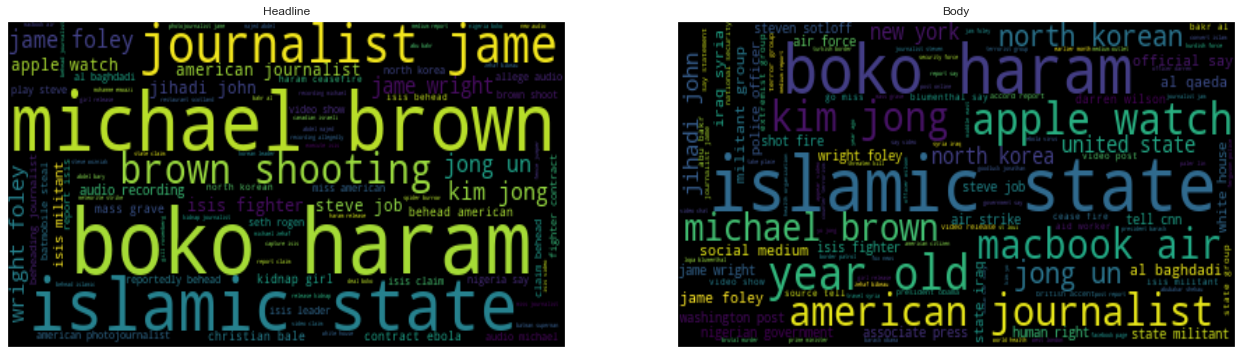

In [214]:
def concat_words(cls):
    """cls : (str)class of categorical class"""
    body_text = " ".join(sent for sent in news[news['Stance']==cls].body_lemma)
    head_text = " ".join(sent for sent in news[news['Stance']==cls].head_lemma)
    
    return body_text, head_text

def WCloud(text):
    # Using Wordcloud to see the top most used words by Adepeju
    stops = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stops, background_color="black").generate(text)
    
    return wordcloud

plt.rcParams["axes.grid"] = False

for cls in news['Stance'].unique():
    body, head = concat_words(cls)
    print(cls.upper())
    fig, ax = plt.subplots(1, 2, figsize=(22, 6))

    ax[0].imshow(WCloud(head), interpolation='bilinear', aspect='auto')
    ax[1].imshow(WCloud(body), interpolation='bilinear', aspect='auto')
    ax[0].set_title("Headline")
    ax[1].set_title("Body")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

In [254]:
news['head_lemma'].unique()

array(['police find mass grave body near mexico town student disappear police clash',
       'hundred palestinian flee flood gaza israel open dam',
       'christian bale pass role steve job actor reportedly feel wasn right',
       ..., 'discover new eyewitness account jesus miracle',
       'rumor apple watch feature ram storage',
       'apple watch take hour charge deliver notification wrist'],
      dtype=object)

In [250]:
news['head_lemma'].shape[0]

49972

There are 1631 unique headlines for 49972 articles which says there are around 30 headlines per article. Clearly there are multiple news articles which indicates there are multiple sources of news or there is presence of fake news.


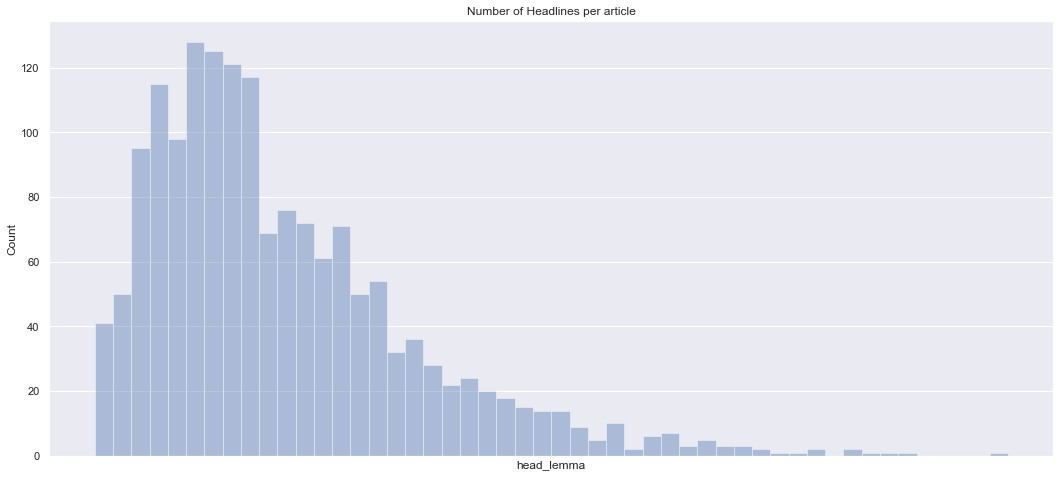

In [286]:
headline_count = news.head_lemma.value_counts()

sns.set()
plt.figure(figsize=(18, 8))
sns.distplot(headline_count, kde=False, bins=50)
plt.xticks([])
plt.ylabel('Count')
plt.title('Number of Headlines per article')
plt.show()

It clearly shows there are many headlines for articles.

In [11]:
news['body_polarity'] = [tb(s).sentiment.polarity for s in news['body_lemma']]
news.head()

,Stance,head_lemma,body_lemma,word_count,body_polarity
0,unrelated,police find mass grave body near mexico town s...,danny boyle direct untitled filmseth rogen eye...,102,0.058333
1,agree,hundred palestinian flee flood gaza israel ope...,hundred palestinian evacuate home sunday morni...,233,-0.043457
2,unrelated,christian bale pass role steve job actor repor...,year old moscow resident hospitalize wound int...,91,-0.055000
3,unrelated,hbo apple talk month apple tv stream service l...,canadian soldier shoot canadian war memorial o...,39,0.050000
4,disagree,spider burrow tourist stomach chest,fear arachnophobe story bunbury spiderman pert...,255,0.127814


UNRELATED


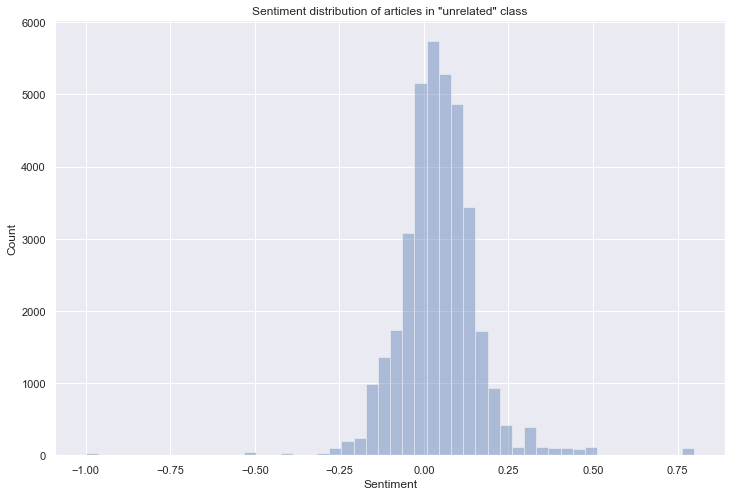

AGREE


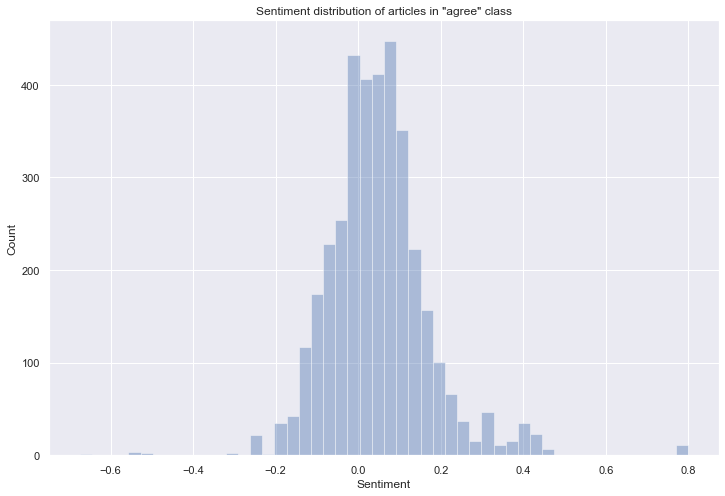

DISAGREE


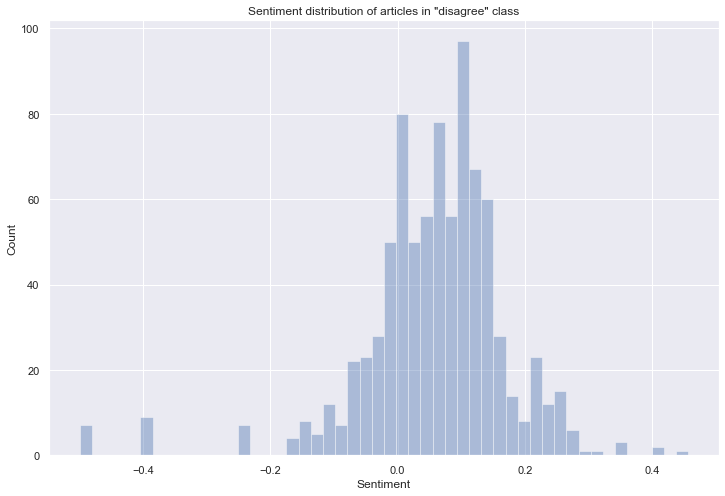

DISCUSS


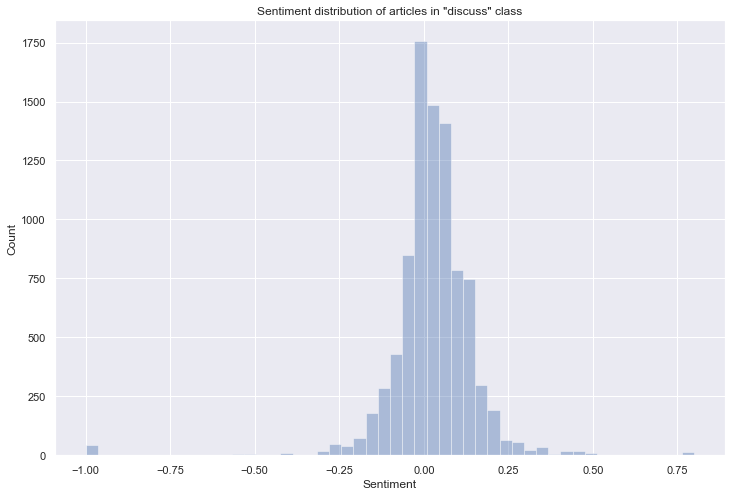

In [297]:
for cls in news.Stance.unique():
    print(cls.upper())
    sns.set()
    plt.figure(figsize=(12, 8))
    ax = sns.distplot(news[news['Stance']==cls].body_polarity, kde=False, bins=50)
    plt.ylabel('Count')
    plt.xlabel('Sentiment')
    plt.title('Sentiment distribution of articles in "{}" class'.format(cls))
    
    heights = [p.get_height() for p in ax.patches]
    for p in ax.patches:
        if  p.get_height() >= third_highest:
            p.set_color('crimson')
    plt.show()

Except DISCUSS class, all articles are more inclined towards positive sentiment as the plots are little skewed towards right. DISAGREE and UNRELATED class articles show more skewness than AGREE class articles.

### Modelling

In [12]:
le = LabelEncoder()
news['Stance'] = le.fit_transform(news['Stance'])

In [12]:
df = news.drop(['word_count', 'body_polarity'], axis=1)
df = df[['head_lemma', 'body_lemma', 'Stance']]
df.head()

,head_lemma,body_lemma,Stance
0,police find mass grave body near mexico town s...,danny boyle direct untitled filmseth rogen eye...,unrelated
1,hundred palestinian flee flood gaza israel ope...,hundred palestinian evacuate home sunday morni...,agree
2,christian bale pass role steve job actor repor...,year old moscow resident hospitalize wound int...,unrelated
3,hbo apple talk month apple tv stream service l...,canadian soldier shoot canadian war memorial o...,unrelated
4,spider burrow tourist stomach chest,fear arachnophobe story bunbury spiderman pert...,disagree


In [5]:
text = "The quick brown fox jumps over the lazy dog."
# remove words between 1 and 3
shortword = re.compile(r'\W*\b\w{1,3}\b')
print(shortword.sub('', text))

 quick brown jumps over lazy.


In [11]:
text = 'yo yo honey singh'
re.sub(r'\W*\b\w{1,2}\b', '', text)

' honey singh'

In [13]:
# removing the non useful words we found in top words list 
remove_wrds_list = ['man', 'say', 'tell', 'report', 'claim']

def clean_text(text): 
    text = re.sub('man|say|tell|report|claim', '', text)
    text = re.sub(' +', ' ', text) #removes extra spaces
    return text

df['head_lemma'] = df['head_lemma'].apply(lambda x: clean_text(x))
df['body_lemma'] = df['body_lemma'].apply(lambda x: clean_text(x))

In [14]:
x = df.drop(['Stance'], axis=1)
y = df['Stance']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

In [15]:
head_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
xtrain_head_vec = head_tfidf.fit_transform(x_train['head_lemma']).toarray()

body_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
xtrain_body_vec = body_tfidf.fit_transform(x_train['body_lemma']).toarray()

xtest_head_vec = head_tfidf.transform(x_test['head_lemma']).toarray()
xtest_body_vec = body_tfidf.transform(x_test['body_lemma']).toarray()

Let's find top features and lowest features.

words which appear most frequently and in almost all the documents have the lowest Idf score and vice-versa.

In [355]:
x_features = np.array(body_tfidf.get_feature_names())
sorted_by_idf = np.argsort(body_tfidf.idf_)

print("features with lowest Idf:\n {}".format(x_features[sorted_by_idf[:10]]))
print("\nfeatures with highest Idf:\n {}".format(x_features[sorted_by_idf[-10:]]))

features with lowest Idf:
 ['year' 'time' 'people' 'come' 'take' 'go' 'accord' 'state' 'news' 'know']

features with highest Idf:
 ['une' 'joshua' 'deandre' 'deandre joshua' 'killer app' 'rourke' 'redact'
 'redact taibbi' 'taibbi quote' 'mm']


In [352]:
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
X = np.hstack((xtrain_head_vec, xtrain_body_vec)) #train vector
x_t = np.hstack((xtest_head_vec, xtest_body_vec)) #test vector

In [25]:
lr = LogisticRegression(C=1.0, solver='lbfgs', class_weight='balanced', max_iter=150)
lr_model = lr.fit(X, y_train)
pred = lr_model.predict(x_t)

C:\Users\Anudeep\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

In [35]:
data.Stance.value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [36]:
news.Stance.value_counts()

3    36545
2     8909
0     3678
1      840
Name: Stance, dtype: int64

In [33]:
accuracy_score(y_test, pred)

0.7265632816408204

In [32]:
cls_rep = classification_report(y_test, pred)
print(cls_rep)

              precision    recall  f1-score   support

           0       0.39      0.69      0.50       767
           1       0.32      0.78      0.45       170
           2       0.54      0.76      0.63      1769
           3       0.92      0.72      0.81      7289

    accuracy                           0.73      9995
   macro avg       0.54      0.74      0.60      9995
weighted avg       0.80      0.73      0.75      9995



In [ ]:
#from sklearn.svm import SVC

#svc = SVC(C=0.8, gamma='scale', decision_function_shape='ovo', kernel='rbf', random_state=123)
#svc_fit = svc.fit(X, y_train)

In [22]:
dtree_model = DecisionTreeClassifier(random_state=123).fit(X, y_train) 
dtree_predictions = dtree_model.predict(x_t) 

In [38]:
cls_rep_dtc = classification_report(y_test, dtree_predictions, output_dict=True)
print(cls_rep_dtc)

{'agree': {'precision': 0.7849462365591398, 'recall': 0.7614080834419817, 'f1-score': 0.772998014559894, 'support': 767}, 'disagree': {'precision': 0.6529411764705882, 'recall': 0.6529411764705882, 'f1-score': 0.6529411764705882, 'support': 170}, 'discuss': {'precision': 0.9072345390898483, 'recall': 0.8790276992651216, 'f1-score': 0.8929084122882573, 'support': 1769}, 'unrelated': {'precision': 0.9717659834396634, 'recall': 0.9821649060227741, 'f1-score': 0.9769377729257642, 'support': 7289}, 'accuracy': 0.9413706853426713, 'macro avg': {'precision': 0.8292219838898099, 'recall': 0.8188854663001164, 'f1-score': 0.823946344061126, 'support': 9995}, 'weighted avg': {'precision': 0.940585684480491, 'recall': 0.9413706853426713, 'f1-score': 0.9409048409566043, 'support': 9995}}


In [32]:
dtree_predictions

array(['unrelated', 'agree', 'unrelated', ..., 'unrelated', 'unrelated',
       'unrelated'], dtype=object)

In [31]:
acc_dtc = accuracy_score(y_test, dtree_predictions)
acc_dtc

0.9413706853426713

In [40]:
confusion_matrix(y_test, dtree_predictions)

array([[ 584,   33,   73,   77],
       [  37,  111,   14,    8],
       [  74,   17, 1555,  123],
       [  49,    9,   72, 7159]], dtype=int64)

In [44]:
from sklearn.linear_model import PassiveAggressiveClassifier as PAC

pac = PAC(C=0.6, n_jobs=-1, random_state=1234, verbose=2)
pac_model = pac.fit(X, y_train)
pac_pred = pac_model.predict(x_t)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


-- Epoch 1
Norm: 19.50, NNZs: 8883, Bias: -2.227790, T: 39977, Avg. loss: 0.053496
Total training time: 1.10 seconds.
-- Epoch 2
Norm: 37.17, NNZs: 9921, Bias: -1.934987, T: 39977, Avg. loss: 0.215305
Total training time: 1.11 seconds.
-- Epoch 2
Norm: 50.28, NNZs: 9994, Bias: -2.399721, T: 39977, Avg. loss: 0.435091
Total training time: 1.20 seconds.
-- Epoch 2
Norm: 57.10, NNZs: 10000, Bias: 0.254248, T: 39977, Avg. loss: 0.639778
Total training time: 1.22 seconds.
-- Epoch 2
Norm: 27.10, NNZs: 9152, Bias: -2.459743, T: 79954, Avg. loss: 0.045594
Total training time: 2.08 seconds.
-- Epoch 3
Norm: 51.53, NNZs: 9965, Bias: -1.537629, T: 79954, Avg. loss: 0.181217
Total training time: 2.14 seconds.
-- Epoch 3
Norm: 67.86, NNZs: 9996, Bias: -1.201882, T: 79954, Avg. loss: 0.364624
Total training time: 2.31 seconds.
-- Epoch 3
Norm: 75.29, NNZs: 10000, Bias: 1.258058, T: 79954, Avg. loss: 0.542576
Total training time: 2.39 seconds.
-- Epoch 3
Norm: 32.42,

Norm: 155.46, NNZs: 10000, Bias: 0.698054, T: 679609, Avg. loss: 0.463407
Total training time: 19.32 seconds.
-- Epoch 18
Norm: 128.65, NNZs: 9991, Bias: -2.025938, T: 799540, Avg. loss: 0.133066
Total training time: 20.22 seconds.
-- Epoch 21
Norm: 146.70, NNZs: 10000, Bias: -3.045773, T: 759563, Avg. loss: 0.298301
Total training time: 20.40 seconds.
-- Epoch 20
Norm: 158.26, NNZs: 10000, Bias: 0.148700, T: 719586, Avg. loss: 0.462025
Total training time: 20.47 seconds.
-- Epoch 19
Norm: 130.70, NNZs: 9991, Bias: -2.353352, T: 839517, Avg. loss: 0.131890
Total training time: 21.19 seconds.
-- Epoch 22
Norm: 148.88, NNZs: 10000, Bias: -2.479164, T: 799540, Avg. loss: 0.299769
Total training time: 21.46 seconds.
Convergence after 20 epochs took 21.46 seconds
Norm: 160.72, NNZs: 10000, Bias: 0.666332, T: 759563, Avg. loss: 0.460050
Total training time: 21.59 seconds.
-- Epoch 20
Norm: 132.49, NNZs: 9991, Bias: -2.977048, T: 879494, Avg. loss: 0.132199
Total training time: 22.17 seconds.

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   29.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   29.6s finished


NameError: name 'confusion_matric' is not defined

In [45]:
acc_pac = accuracy_score(y_test, pac_pred)
cm_pac = confusion_matrix(y_test, pac_pred)
cls_rep_pac = classification_report(y_test, pac_pred)

print(acc_pac)
print(cm_pac)
print(cls_rep_pac)

0.831815907953977
[[ 347   15   73  332]
 [  32   40   31   67]
 [   6    2 1157  604]
 [  98    7  414 6770]]
              precision    recall  f1-score   support

       agree       0.72      0.45      0.56       767
    disagree       0.62      0.24      0.34       170
     discuss       0.69      0.65      0.67      1769
   unrelated       0.87      0.93      0.90      7289

    accuracy                           0.83      9995
   macro avg       0.73      0.57      0.62      9995
weighted avg       0.82      0.83      0.82      9995



In [12]:
dat = pd.DataFrame(cls_rep_dtc).transpose()
dat

NameError: name 'cls_rep_dtc' is not defined

In [75]:
concat_data = news[['head_lemma', 'body_lemma', 'Stance']]
concat_data['news'] = concat_data['head_lemma']+concat_data['body_lemma']
concat_data = concat_data.drop(['head_lemma', 'body_lemma'], axis=1)
concat_data.head()

C:\Users\Anudeep\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Stance,news
0,unrelated,police find mass grave body near mexico town s...
1,agree,hundred palestinian flee flood gaza israel ope...
2,unrelated,christian bale pass role steve job actor repor...
3,unrelated,hbo apple talk month apple tv stream service l...
4,disagree,spider burrow tourist stomach chestfear arachn...


In [76]:
#from keras.utils import to_categorical

concat_data['Stance'] = le.fit_transform(concat_data['Stance'])
concat_data.head()

,Stance,news
0,3,police find mass grave body near mexico town s...
1,0,hundred palestinian flee flood gaza israel ope...
2,3,christian bale pass role steve job actor repor...
3,3,hbo apple talk month apple tv stream service l...
4,1,spider burrow tourist stomach chestfear arachn...


In [77]:
x = concat_data.news
y = concat_data.Stance
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

In [78]:
num_words = 10000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)

maxlen = 500

train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)


In [15]:
word_index = {k:(v+3) for k, v in word_index.items()}
word_index['<PAD>'] = 0
word_index['<START>'] = 1

In [79]:
reverse_word_index = {v: k for k, v in word_index.items()}
reverse_word_index

{1: '<UNK>',
 2: 'say',
 3: 'report',
 4: 'state',
 5: 'video',
 6: 'tell',
 7: 'year',
 8: 'apple',
 9: 'isis',
 10: 'man',
 11: 'time',
 12: 'people',
 13: 'new',
 14: 'group',
 15: 'claim',
 16: 'watch',
 17: 'news',
 18: 'official',
 19: 'go',
 20: 'islamic',
 21: 'al',
 22: 'come',
 23: 'take',
 24: 'accord',
 25: 'know',
 26: 'government',
 27: 'syria',
 28: 'militant',
 29: 'release',
 30: 'kim',
 31: 'post',
 32: 'american',
 33: 'police',
 34: 'day',
 35: 'foley',
 36: 'kill',
 37: 'like',
 38: 's',
 39: 'story',
 40: 'medium',
 41: 'find',
 42: 'iraq',
 43: 'north',
 44: 'force',
 45: 'source',
 46: 'include',
 47: 'confirm',
 48: 'work',
 49: 'old',
 50: 'show',
 51: 'week',
 52: 'appear',
 53: 'city',
 54: 'attack',
 55: 'month',
 56: 'woman',
 57: 'believe',
 58: 'girl',
 59: 'brown',
 60: 'think',
 61: 'leader',
 62: 'see',
 63: 'leave',
 64: 'security',
 65: 'fighter',
 66: 'journalist',
 67: 'family',
 68: 'air',
 69: 'hold',
 70: 'border',
 71: 'world',
 72: 'hear',
 7

In [80]:
def decode_review(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

print(decode_review(test_sequences[1]))

obama denounce jame foley execution today entire world <UNK> obama declare entire world appal beheading american journalist militant syria vow america change course iraq united state conduct airstrike terrorist despite threat group kill reporter day ahead united state america continue protect people mr obama say brief statement martha vineyard vacation vigilant relentless speak reporter mr obama say place phone parent jame foley slay reporter tell american heartbroken loss describe mr foley journalist son brother friend take act violence shock conscience entire world president harsh emotional word reserve islamic state iraq syria militant release video killing mr foley tuesday american intelligence agency wednesday verify authenticity video show masked man <UNK> jame foley american journalist kidnap syria nearly year ago show american captive journalist steven sotloff warn die president call isis cancer region accuse have rampage city village kill unarmed civilian cowardly act violence

In [81]:
#from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed
from tensorflow import keras

In [82]:
model = keras.Sequential()
model.add(keras.layers.Embedding(10000, 64, input_length=maxlen))
model.add(keras.layers.Conv1D(128, 5, activation="relu"))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv1D(64, 5, activation="relu"))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 496, 128)          41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 248, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 248, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 244, 64)           41024     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 122, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7808)             

In [83]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


'training_1'

In [13]:
data.head()

NameError: name 'data' is not defined

In [84]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

x_trn = np.array(train_padded[:37000])
x_val = np.array(train_padded[37000:])
y_trn = np.array(y_train[:37000])
y_val = np.array(y_train[37000:])

#print(len(x_trn), len(y_trn))

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)


history = model.fit(x_trn, y_trn, epochs=20, batch_size=512, validation_data=(x_val, y_val), callbacks=[cp_callback], verbose=1)

Train on 37000 samples, validate on 2977 samples
Epoch 1/20
36864/37000 [============================>.] - ETA: 0s - loss: 0.8062 - acc: 0.7253
Epoch 00001: saving model to training_1/cp.ckpt
37000/37000 [==============================] - 86s 2ms/sample - loss: 0.8059 - acc: 0.7254 - val_loss: 0.7127 - val_acc: 0.7330
Epoch 2/20
36864/37000 [============================>.] - ETA: 0s - loss: 0.6422 - acc: 0.7659
Epoch 00002: saving model to training_1/cp.ckpt
37000/37000 [==============================] - 88s 2ms/sample - loss: 0.6423 - acc: 0.7659 - val_loss: 0.6380 - val_acc: 0.7843
Epoch 3/20
36864/37000 [============================>.] - ETA: 0s - loss: 0.5836 - acc: 0.7853
Epoch 00003: saving model to training_1/cp.ckpt
37000/37000 [==============================] - 88s 2ms/sample - loss: 0.5833 - acc: 0.7855 - val_loss: 0.6073 - val_acc: 0.7817
Epoch 4/20
36864/37000 [============================>.] - ETA: 0s - loss: 0.5424 - acc: 0.7958
Epoch 00004: saving model to training_1/cp.

In [85]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1, len(acc)+1)

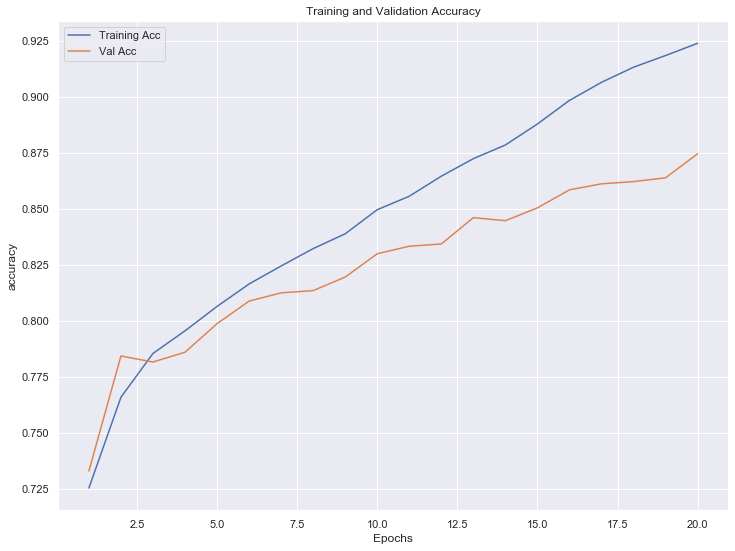

In [86]:
sns.set()
plt.figure(figsize=(12, 9))
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [22]:
results = model.evaluate(test_padded, y_test)
results

9995/9995 [==============================] - 5s 465us/sample - loss: 0.3779 - acc: 0.8840


[0.37786185115933596, 0.884042]

In [25]:
model.save('conv_model.h5')

In [42]:
np.array(y_test)[0]

3

In [87]:
model.evaluate(test_padded, y_test)

9995/9995 [==============================] - 5s 467us/sample - loss: 0.4051 - acc: 0.8753


[0.4051053027605164, 0.87533766]

In [89]:
conv_pred = model.predict_classes(test_padded)

acc_conv = accuracy_score(y_test, conv_pred)
cm_conv = confusion_matrix(y_test, conv_pred)
cls_rep_conv = classification_report(y_test, conv_pred)

print(acc_pac)
print(cm_pac)
print(cls_rep_pac)

0.831815907953977
[[ 347   15   73  332]
 [  32   40   31   67]
 [   6    2 1157  604]
 [  98    7  414 6770]]
              precision    recall  f1-score   support

       agree       0.72      0.45      0.56       767
    disagree       0.62      0.24      0.34       170
     discuss       0.69      0.65      0.67      1769
   unrelated       0.87      0.93      0.90      7289

    accuracy                           0.83      9995
   macro avg       0.73      0.57      0.62      9995
weighted avg       0.82      0.83      0.82      9995



### Out of all the models (LogisticRegression, DecisionTree, PassiveAgrressiveClassifier, SVC and Keras conv models), DecisionTree performed the best with 94% accuracy and weighted f1 score of 96%. 

### With deep learning architecture, i have tried baseline models from simple neural layers to tuning convultional kernel size and number of layers to LSTM and bidirectional lstms with Time distributed layers. But the system did not support the latter architectures. 

PS: Due to time constraints and resource constraints, i wasn't able to tune hyper parameters for every algorithm as the system keeps hanging and takes forever to run for some algorithms. After multiple efforts and lot of unncecessary re-training times, I decided to end it as the model tuning can be done with little work. I would be happy to discuss with you on the algorithms and tuning parameters in the interview. Kindly consider this. Thank you!